# Project 3, Part 4 - Hypothesis Testing

## Author:  Sheneka Allen



For Part 4 of the project, you will be using your MySQL database from Part 3 
to answer meaningful questions for your stakeholder. Use hypothesis testing and statistics knowledge to answer at least 3 questions about what makes a successful movie.

## Deliverables

### You should use the same project repository you have been using for Parts 1-3 (for your portfolio).

### Create a new notebook in your project repository just for the hypothesis testing 

### (like "Part 4 - Hypothesis Testing.ipynb")

### Make sure the results and visualization for all 3 hypotheses are in your notebook.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, json, math, time
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

import pymysql
pymysql.install_as_MySQLdb()

from urllib.parse import quote_plus as urlquote # must have for special char pwd
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

import scipy.stats as stats



In [2]:
# load basics_cleaned .csv.gz file into basics variable
basics = pd.read_csv('Data/title_basics_cleaned.csv.gz')
basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205530 entries, 0 to 205529
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          205530 non-null  object
 1   titleType       205530 non-null  object
 2   primaryTitle    205530 non-null  object
 3   originalTitle   205530 non-null  object
 4   isAdult         205530 non-null  int64 
 5   startYear       205530 non-null  int64 
 6   endYear         205530 non-null  int64 
 7   runtimeMinutes  205530 non-null  int64 
 8   genres          205530 non-null  object
dtypes: int64(4), object(5)
memory usage: 14.1+ MB


In [3]:
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,0,0,"Action,Crime"
1,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000,0,60,Missing
2,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,0,118,"Comedy,Fantasy,Romance"
3,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,0,70,Drama
4,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,0,122,Drama


In [4]:
# use sorted method to return data in sequential or alpha order
sorted(basics.startYear.unique())

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

In [5]:
# Load my TMDb login credentials
with open('/Users/shenekaallen/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
    
## Display the keys of the loaded dict
login.keys()

dict_keys(['API Key', 'Authorization'])

In [6]:
# set the tmdbapi variable equal to my unique TMDb "API Key(v3 auth)" entry in JSON file
tmdb.API_KEY =  login['API Key']

## Setup to use TMDB API

Define functions, Specify movie Years to extract and folder to save results

### Defined Function: get_movie_with_rating

In [7]:
# function that 1) accepts the movie_id as an argument and
# 2) returns a dictionary of results that includes certification
def get_movie_with_rating(movie_id):
    ## Get movie and release dates
    movie = tmdb.Movies(movie_id)
    ## Construct output dict
    movie_info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            movie_info['certification'] = c['certification']
    return movie_info

### Defined Function: write_json

In [8]:
def write_json(new_data, filename):
    """Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
            file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [9]:
# Define years to collect from movie db and store in a variable
YEARS_TO_GET = [2020,2021]

In [10]:
# Specify folder for saving data in Python vs Jupyter Notebook
FOLDER = "Data/"
# list current files in Data/
sorted(os.listdir(FOLDER))

['.DS_Store',
 '.ipynb_checkpoints',
 'combined_00011819_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2018.csv.gz',
 'final_tmdb_data_2019.csv.gz',
 'title.akas.tsv',
 'title.akas.tsv.gz',
 'title.basics.tsv.gz',
 'title.ratings.tsv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2019.json',
 'tmdb_results_combined.csv.gz']

### Test data extraction for 2018 & 2019 Year Movie Releases

### OUTER Loop to collect data by YEAR

Checks if JSON file exists, if not, creates and writes select query data to the file.

Identifies the designated FOLDER (Data/) and names the file based on the current year. Saves data in separate .csv.gz files BY YEAR.

### INNER Loop to collect index and movie ID

In [14]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',position=0):
    
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
     # If it does not exist: create it
    if file_exists == False:
        ## If it does not exist:
        print('The year', YEAR, 'file does not exist.  Creating empty file.')
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    else:
        print('The year', YEAR, 'file already exists.')
        

    #Saving new year as the current df
    df = basics.loc[basics['startYear'] == YEAR].copy()
    # saving movie ids to list
    movie_id = df['tconst'].copy()#.to_list()
 
    # Load existing data from json into a dataframe called "previous_basics"
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_id_to_get = movie_id[~movie_id.isin(previous_df['imdb_id'])]
        
    # Get index and movie id from list
    # This loop uses 2 functions: 1) "get_movie_with_rating" to add the certification to the .info results 
    # and 2) "write_json" to extend/append the results to the .json file. 
    
    # INNER Loop
    for movie_id in tqdm_notebook(movie_id_to_get,
                          desc=f'Movies from {YEAR}',
                          position=1,
                          leave=True):
        # Attempt to retrieve the data for the movie id
        try:
            temp = get_movie_with_rating(movie_id)  #This uses your pre-made function
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            # If it fails,  make a dict with just the id and None for certification.
        except Exception as e: 
            continue

    ## Saving filtered file as csv.gz
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

The year 2018 file does not exist.  Creating empty file.


Movies from 2018:   0%|          | 0/13973 [00:00<?, ?it/s]

The year 2019 file does not exist.  Creating empty file.


Movies from 2019:   0%|          | 0/13358 [00:00<?, ?it/s]

In [11]:
# read movie 2018 records extracted
# Reused code:  https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data
## code below corrects CParserError: Error tokenizing data. C error

tmdb_data_2018 = pd.read_csv('Data/final_tmdb_data_2018.csv.gz', encoding='utf8', engine='python')
tmdb_data_2018.info()
tmdb_data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7871 entries, 0 to 7870
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                7871 non-null   object 
 1   adult                  7850 non-null   float64
 2   backdrop_path          5194 non-null   object 
 3   belongs_to_collection  345 non-null    object 
 4   budget                 7850 non-null   object 
 5   genres                 7850 non-null   object 
 6   homepage               1777 non-null   object 
 7   id                     7850 non-null   float64
 8   original_language      7850 non-null   object 
 9   original_title         7850 non-null   object 
 10  overview               7253 non-null   object 
 11  popularity             7844 non-null   object 
 12  poster_path            7545 non-null   object 
 13  production_companies   7844 non-null   object 
 14  production_countries   7844 non-null   object 
 15  rele

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069049,0.0,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782.0,en,The Other Side of the Wind,...,0.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making,The Other Side of the Wind,0.0,6.7,155.0,R
2,tt0137818,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",NaN,748589.0,en,Housesitter: The Night They Saved Siegfried's ...,...,0.0,0.0,[],Released,NaN,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,0.0,NaN
3,tt0192528,0.0,/gkBxjhtVEqgxOiRwRfWw1j7ez6K.jpg,NaN,5000000.0,"[{'id': 18, 'name': 'Drama'}]",NaN,567662.0,en,Reverse Heaven,...,0.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Heaven's in trouble and there's one man who ca...,Heaven & Hell,0.0,6.3,6.0,NaN
4,tt0328810,0.0,NaN,NaN,0.0,[],NaN,284625.0,en,Aamaar Bhuvan,...,0.0,107.0,"[{'english_name': 'Bengali', 'iso_639_1': 'bn'...",Released,NaN,Aamaar Bhuvan,0.0,6.3,3.0,NaN


In [12]:
tmdb_data_2019 = pd.read_csv('Data/final_tmdb_data_2019.csv.gz', encoding='utf8', engine='python')
tmdb_data_2019.info()
tmdb_data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                7721 non-null   object 
 1   adult                  7698 non-null   float64
 2   backdrop_path          5394 non-null   object 
 3   belongs_to_collection  333 non-null    object 
 4   budget                 7698 non-null   object 
 5   genres                 7696 non-null   object 
 6   homepage               1656 non-null   object 
 7   id                     7698 non-null   float64
 8   original_language      7698 non-null   object 
 9   original_title         7698 non-null   object 
 10  overview               7203 non-null   object 
 11  popularity             7693 non-null   object 
 12  poster_path            7476 non-null   object 
 13  production_companies   7693 non-null   object 
 14  production_countries   7693 non-null   object 
 15  rele

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0011801,0.0,NaN,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,611205.0,de,Tötet nicht mehr!,...,0.0,127.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Misericordia,0.0,0.0,0.0,NaN
2,tt0083060,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,288533.0,zh,沙鸥,...,0.0,84.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,NaN,The Drive to Win,0.0,6.0,1.0,NaN
3,tt0195933,0.0,/wOl8ZAdGcO7UhzweAFZb0qVFrjh.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...",NaN,334136.0,en,The Mysteries,...,0.0,64.0,"[{'english_name': 'No Language', 'iso_639_1': ...",Released,NaN,The Mysteries,0.0,0.0,0.0,NaN
4,tt0276132,0.0,NaN,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 18, '...",NaN,633838.0,en,The Fetishist,...,0.0,38.0,[],Released,NaN,The Fetishist,0.0,0.0,0.0,NaN


In [13]:
# glob takes a filename and returns results that match the pattern provided
import glob
# Make a filepath query
q = FOLDER+"final*.csv.gz"
q

'Data/final*.csv.gz'

In [14]:
# Use glob.glob to get COMPLETE filepaths
file_list = glob.glob(q)
sorted(file_list)

['Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2018.csv.gz',
 'Data/final_tmdb_data_2019.csv.gz']

In [15]:
# use a list comprehension to load in all files into one dataframe
## basically create an empty list, read in each df by year then append each year's dataframe to the next

tmdbYR_combo_df = pd.concat([pd.read_csv(file, lineterminator='\n') for file in file_list])
tmdbYR_combo_df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069049,0.0,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782.0,en,The Other Side of the Wind,...,0.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making,The Other Side of the Wind,0.0,6.7,155.0,R
2,tt0137818,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",NaN,748589.0,en,Housesitter: The Night They Saved Siegfried's ...,...,0.0,0.0,[],Released,NaN,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,0.0,NaN
3,tt0192528,0.0,/gkBxjhtVEqgxOiRwRfWw1j7ez6K.jpg,NaN,5000000.0,"[{'id': 18, 'name': 'Drama'}]",NaN,567662.0,en,Reverse Heaven,...,0.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Heaven's in trouble and there's one man who ca...,Heaven & Hell,0.0,6.3,6.0,NaN
4,tt0328810,0.0,NaN,NaN,0.0,[],NaN,284625.0,en,Aamaar Bhuvan,...,0.0,107.0,"[{'english_name': 'Bengali', 'iso_639_1': 'bn'...",Released,NaN,Aamaar Bhuvan,0.0,6.3,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649,tt9071078,0.0,NaN,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",http://www.hkcinemagic.com/en/movie.asp?id=6627,201706.0,cn,致命密函,...,0.0,90.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Chinese Heroes,0.0,3.0,2.0,NaN
2650,tt9099724,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,616033.0,ja,Rokushukan Private Moment,...,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rokushukan Private Moment,0.0,0.0,0.0,NaN
2651,tt9501738,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,481617.0,zh,绝对情感,...,0.0,87.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,NaN,Pure Sentiment,0.0,0.0,0.0,NaN
2652,tt9789230,0.0,NaN,NaN,0.0,[],NaN,986785.0,en,Girls Who Like Girls,...,0.0,89.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Girls Who Like Girls,0.0,0.0,0.0,NaN


In [16]:
# remove ids that are 0
# remember, imdb_id is an object, so 0 is a string here

tmdbYR_combo_df = tmdbYR_combo_df.loc[tmdbYR_combo_df["imdb_id"]!='0']
tmdbYR_combo_df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0069049,0.0,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782.0,en,The Other Side of the Wind,...,0.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making,The Other Side of the Wind,0.0,6.7,155.0,R
2,tt0137818,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",NaN,748589.0,en,Housesitter: The Night They Saved Siegfried's ...,...,0.0,0.0,[],Released,NaN,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,0.0,NaN
3,tt0192528,0.0,/gkBxjhtVEqgxOiRwRfWw1j7ez6K.jpg,NaN,5000000.0,"[{'id': 18, 'name': 'Drama'}]",NaN,567662.0,en,Reverse Heaven,...,0.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Heaven's in trouble and there's one man who ca...,Heaven & Hell,0.0,6.3,6.0,NaN
4,tt0328810,0.0,NaN,NaN,0.0,[],NaN,284625.0,en,Aamaar Bhuvan,...,0.0,107.0,"[{'english_name': 'Bengali', 'iso_639_1': 'bn'...",Released,NaN,Aamaar Bhuvan,0.0,6.3,3.0,NaN
5,tt0360556,0.0,/7oy4miyq4WYYy0xtX6lbNVPrEsr.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",https://www.hbo.com/movies/fahrenheit-451,401905.0,en,Fahrenheit 451,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Knowledge is a dangerous thing,Fahrenheit 451,0.0,5.4,697.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649,tt9071078,0.0,NaN,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",http://www.hkcinemagic.com/en/movie.asp?id=6627,201706.0,cn,致命密函,...,0.0,90.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Chinese Heroes,0.0,3.0,2.0,NaN
2650,tt9099724,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,616033.0,ja,Rokushukan Private Moment,...,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rokushukan Private Moment,0.0,0.0,0.0,NaN
2651,tt9501738,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,481617.0,zh,绝对情感,...,0.0,87.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,NaN,Pure Sentiment,0.0,0.0,0.0,NaN
2652,tt9789230,0.0,NaN,NaN,0.0,[],NaN,986785.0,en,Girls Who Like Girls,...,0.0,89.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Girls Who Like Girls,0.0,0.0,0.0,NaN


In [17]:
# save combined csv to disk
tmdbYR_combo_df.to_csv('Data/combined_00011819_data.csv.gz', compression='gzip', index=False)

In [18]:
# list column names
list(tmdbYR_combo_df.columns)

['imdb_id',
 'adult',
 'backdrop_path',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'certification']

In [19]:
# columns to exclude
drop_cols = ['backdrop_path', 'original_title', 'overview', 'poster_path', 'status', 
             'tagline', 'id', 'homepage', 'production_countries', 'video', 
             'production_companies', 'spoken_languages', 'original_language' ]

# drop columns
tmdbYR_combo_df.drop(columns=drop_cols, inplace=True) 
tmdbYR_combo_df

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification
1,tt0069049,0.0,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}]",8.709,2018-11-02,0.0,122.0,The Other Side of the Wind,6.7,155.0,R
2,tt0137818,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,NaN
3,tt0192528,0.0,NaN,5000000.0,"[{'id': 18, 'name': 'Drama'}]",1.237,2018-11-06,0.0,104.0,Heaven & Hell,6.3,6.0,NaN
4,tt0328810,0.0,NaN,0.0,[],0.681,2002-04-01,0.0,107.0,Aamaar Bhuvan,6.3,3.0,NaN
5,tt0360556,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",17.214,2018-05-12,0.0,100.0,Fahrenheit 451,5.4,697.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649,tt9071078,0.0,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",0.600,2001-07-12,0.0,90.0,Chinese Heroes,3.0,2.0,NaN
2650,tt9099724,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-01,0.0,102.0,Rokushukan Private Moment,0.0,0.0,NaN
2651,tt9501738,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-31,0.0,87.0,Pure Sentiment,0.0,0.0,NaN
2652,tt9789230,0.0,NaN,0.0,[],0.600,2001-06-10,0.0,89.0,Girls Who Like Girls,0.0,0.0,NaN


In [20]:
# reset index, pass inplace=True to apply change to df
tmdbYR_combo_df.reset_index(drop=True, inplace=True)
tmdbYR_combo_df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,tt0069049,0.0,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}]",8.709,2018-11-02,0.0,122.0,The Other Side of the Wind,6.7,155.0,R
1,tt0137818,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,NaN
2,tt0192528,0.0,NaN,5000000.0,"[{'id': 18, 'name': 'Drama'}]",1.237,2018-11-06,0.0,104.0,Heaven & Hell,6.3,6.0,NaN
3,tt0328810,0.0,NaN,0.0,[],0.681,2002-04-01,0.0,107.0,Aamaar Bhuvan,6.3,3.0,NaN
4,tt0360556,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",17.214,2018-05-12,0.0,100.0,Fahrenheit 451,5.4,697.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,tt9071078,0.0,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",0.600,2001-07-12,0.0,90.0,Chinese Heroes,3.0,2.0,NaN
20758,tt9099724,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-01,0.0,102.0,Rokushukan Private Moment,0.0,0.0,NaN
20759,tt9501738,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-31,0.0,87.0,Pure Sentiment,0.0,0.0,NaN
20760,tt9789230,0.0,NaN,0.0,[],0.600,2001-06-10,0.0,89.0,Girls Who Like Girls,0.0,0.0,NaN


In [21]:
# just keep rows with values for 'name' in belong to collections column
tmdbYR_combo_df['belongs_to_collection'] = ~tmdbYR_combo_df['belongs_to_collection'].isna()#saves BOOLEAN value of True in df
tmdbYR_combo_df['belongs_to_collection'].value_counts(dropna=False)# drops records with BOOLEAN = False for NaN values

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


False    19844
True       918
Name: belongs_to_collection, dtype: int64

In [22]:
# just get genres name as a list
tmdbYR_combo_df.loc[7, 'genres']

"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 9648, 'name': 'Mystery'}]"

In [23]:
# function to get only genre names as a list
def get_genre_name(x):
    x = x.replace("'", '"')#find single quote, replace with double quote
    x = json.loads(x)
    
    genres = [] #create empty list
    for genre in x:
        genres.append(genre['name'])#append movie name to its genre
    return genres

In [24]:
# test get_genre_name function on 1 record
get_genre_name(tmdbYR_combo_df.loc[7, 'genres'])

['Comedy', 'Crime', 'Mystery']

In [25]:
# use get_genre_name function on entire tmdbYR df and assign values to new column, genres_list
tmdbYR_combo_df['genre_list'] = tmdbYR_combo_df['genres'].apply(get_genre_name)
tmdbYR_combo_df

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,genre_list
0,tt0069049,0.0,False,12000000.0,"[{'id': 18, 'name': 'Drama'}]",8.709,2018-11-02,0.0,122.0,The Other Side of the Wind,6.7,155.0,R,[Drama]
1,tt0137818,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,NaN,"[Horror, Comedy]"
2,tt0192528,0.0,False,5000000.0,"[{'id': 18, 'name': 'Drama'}]",1.237,2018-11-06,0.0,104.0,Heaven & Hell,6.3,6.0,NaN,[Drama]
3,tt0328810,0.0,False,0.0,[],0.681,2002-04-01,0.0,107.0,Aamaar Bhuvan,6.3,3.0,NaN,[]
4,tt0360556,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",17.214,2018-05-12,0.0,100.0,Fahrenheit 451,5.4,697.0,PG-13,"[Drama, Science Fiction, Thriller]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,tt9071078,0.0,False,0.0,"[{'id': 28, 'name': 'Action'}]",0.600,2001-07-12,0.0,90.0,Chinese Heroes,3.0,2.0,NaN,[Action]
20758,tt9099724,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-01,0.0,102.0,Rokushukan Private Moment,0.0,0.0,NaN,[Drama]
20759,tt9501738,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-31,0.0,87.0,Pure Sentiment,0.0,0.0,NaN,[Drama]
20760,tt9789230,0.0,False,0.0,[],0.600,2001-06-10,0.0,89.0,Girls Who Like Girls,0.0,0.0,NaN,[]


In [26]:
# explode new genre_list column into individual strings for each record
tmdbYR_combo_df_explode = tmdbYR_combo_df.explode('genre_list')
tmdbYR_combo_df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,genre_list
0,tt0069049,0.0,False,12000000.0,"[{'id': 18, 'name': 'Drama'}]",8.709,2018-11-02,0.0,122.0,The Other Side of the Wind,6.7,155.0,R,Drama
1,tt0137818,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,NaN,Horror
1,tt0137818,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,NaN,Comedy
2,tt0192528,0.0,False,5000000.0,"[{'id': 18, 'name': 'Drama'}]",1.237,2018-11-06,0.0,104.0,Heaven & Hell,6.3,6.0,NaN,Drama
3,tt0328810,0.0,False,0.0,[],0.681,2002-04-01,0.0,107.0,Aamaar Bhuvan,6.3,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,tt9071078,0.0,False,0.0,"[{'id': 28, 'name': 'Action'}]",0.600,2001-07-12,0.0,90.0,Chinese Heroes,3.0,2.0,NaN,Action
20758,tt9099724,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-01,0.0,102.0,Rokushukan Private Moment,0.0,0.0,NaN,Drama
20759,tt9501738,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-31,0.0,87.0,Pure Sentiment,0.0,0.0,NaN,Drama
20760,tt9789230,0.0,False,0.0,[],0.600,2001-06-10,0.0,89.0,Girls Who Like Girls,0.0,0.0,NaN,NaN


In [27]:
# get unique genre_list values
tmdbYR_combo_df_explode['genre_list'].unique()

array(['Drama', 'Horror', 'Comedy', nan, 'Science Fiction', 'Thriller',
       'Romance', 'Crime', 'Mystery', 'Documentary', 'Music', 'Action',
       'Fantasy', 'Family', 'History', 'TV Movie', 'Animation',
       'Adventure', 'Western', 'War'], dtype=object)

In [28]:
#drop nulls from genre_list column, return unique genres and store values in unique_genres
unique_genres = tmdbYR_combo_df_explode['genre_list'].dropna().unique()
unique_genres

array(['Drama', 'Horror', 'Comedy', 'Science Fiction', 'Thriller',
       'Romance', 'Crime', 'Mystery', 'Documentary', 'Music', 'Action',
       'Fantasy', 'Family', 'History', 'TV Movie', 'Animation',
       'Adventure', 'Western', 'War'], dtype=object)

In [29]:
# Manually one-hot-encode genres
## read through unique_genres df and for each genre, create new column "Genre_(genre name)"
## set regular expression (regex=False) bc genre is the string
for genre in unique_genres:
    tmdbYR_combo_df[f"Genre_{genre}"] = tmdbYR_combo_df['genres'].str.contains(genre,regex=False)
    
tmdbYR_combo_df

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,...,Genre_Music,Genre_Action,Genre_Fantasy,Genre_Family,Genre_History,Genre_TV Movie,Genre_Animation,Genre_Adventure,Genre_Western,Genre_War
0,tt0069049,0.0,False,12000000.0,"[{'id': 18, 'name': 'Drama'}]",8.709,2018-11-02,0.0,122.0,The Other Side of the Wind,...,False,False,False,False,False,False,False,False,False,False
1,tt0137818,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,...,False,False,False,False,False,False,False,False,False,False
2,tt0192528,0.0,False,5000000.0,"[{'id': 18, 'name': 'Drama'}]",1.237,2018-11-06,0.0,104.0,Heaven & Hell,...,False,False,False,False,False,False,False,False,False,False
3,tt0328810,0.0,False,0.0,[],0.681,2002-04-01,0.0,107.0,Aamaar Bhuvan,...,False,False,False,False,False,False,False,False,False,False
4,tt0360556,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",17.214,2018-05-12,0.0,100.0,Fahrenheit 451,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,tt9071078,0.0,False,0.0,"[{'id': 28, 'name': 'Action'}]",0.600,2001-07-12,0.0,90.0,Chinese Heroes,...,False,True,False,False,False,False,False,False,False,False
20758,tt9099724,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-01,0.0,102.0,Rokushukan Private Moment,...,False,False,False,False,False,False,False,False,False,False
20759,tt9501738,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2001-12-31,0.0,87.0,Pure Sentiment,...,False,False,False,False,False,False,False,False,False,False
20760,tt9789230,0.0,False,0.0,[],0.600,2001-06-10,0.0,89.0,Girls Who Like Girls,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# drop columns
tmdbYR_combo_df.drop(columns=['genres', 'genre_list'], inplace=True) 
tmdbYR_combo_df

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,imdb_id,adult,belongs_to_collection,budget,popularity,release_date,revenue,runtime,title,vote_average,...,Genre_Music,Genre_Action,Genre_Fantasy,Genre_Family,Genre_History,Genre_TV Movie,Genre_Animation,Genre_Adventure,Genre_Western,Genre_War
0,tt0069049,0.0,False,12000000.0,8.709,2018-11-02,0.0,122.0,The Other Side of the Wind,6.7,...,False,False,False,False,False,False,False,False,False,False
1,tt0137818,0.0,False,0.0,0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,...,False,False,False,False,False,False,False,False,False,False
2,tt0192528,0.0,False,5000000.0,1.237,2018-11-06,0.0,104.0,Heaven & Hell,6.3,...,False,False,False,False,False,False,False,False,False,False
3,tt0328810,0.0,False,0.0,0.681,2002-04-01,0.0,107.0,Aamaar Bhuvan,6.3,...,False,False,False,False,False,False,False,False,False,False
4,tt0360556,0.0,False,0.0,17.214,2018-05-12,0.0,100.0,Fahrenheit 451,5.4,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,tt9071078,0.0,False,0.0,0.600,2001-07-12,0.0,90.0,Chinese Heroes,3.0,...,False,True,False,False,False,False,False,False,False,False
20758,tt9099724,0.0,False,0.0,0.600,2001-12-01,0.0,102.0,Rokushukan Private Moment,0.0,...,False,False,False,False,False,False,False,False,False,False
20759,tt9501738,0.0,False,0.0,0.600,2001-12-31,0.0,87.0,Pure Sentiment,0.0,...,False,False,False,False,False,False,False,False,False,False
20760,tt9789230,0.0,False,0.0,0.600,2001-06-10,0.0,89.0,Girls Who Like Girls,0.0,...,False,False,False,False,False,False,False,False,False,False


In [31]:
# check for inconsistencies

## value.counts(dropna=False) lets you see null count
tmdbYR_combo_df['certification'].value_counts(dropna=False)

NaN        18108
R           1091
NR           644
PG-13        541
PG           240
G            107
NC-17         29
Unrated        1
-              1
Name: certification, dtype: int64

In [32]:
# correct inconsistencies
tmdbYR_combo_df['certification']=tmdbYR_combo_df['certification'].str.replace('Unrated','NR').fillna('Missing')
tmdbYR_combo_df['certification']=tmdbYR_combo_df['certification'].str.replace('-','NR')
tmdbYR_combo_df['certification'].value_counts(dropna=False)

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Missing    18108
R           1091
NR           646
PGNR13       541
PG           240
G            107
NCNR17        29
Name: certification, dtype: int64

In [33]:
tmdbYR_combo_df['release_date'].value_counts(dropna=False)

NaN           559
2000-01-01    321
2001-01-01    292
2018-01-01    184
2019-01-01    102
             ... 
2021-09-29      1
2014-12-12      1
2022-05-04      1
2021-07-28      1
2004-07-08      1
Name: release_date, Length: 2172, dtype: int64

In [34]:
# split the release_date column string

# create 2 new columns, release_year and release_mo_day by splitting the release_date column
tmdbYR_combo_df[['release_year','release_month', 'release_day']] = tmdbYR_combo_df['release_date'].str.split('-', expand=True)
tmdbYR_combo_df

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,imdb_id,adult,belongs_to_collection,budget,popularity,release_date,revenue,runtime,title,vote_average,...,Genre_Family,Genre_History,Genre_TV Movie,Genre_Animation,Genre_Adventure,Genre_Western,Genre_War,release_year,release_month,release_day
0,tt0069049,0.0,False,12000000.0,8.709,2018-11-02,0.0,122.0,The Other Side of the Wind,6.7,...,False,False,False,False,False,False,False,2018,11,02
1,tt0137818,0.0,False,0.0,0.618,2020-10-02,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,...,False,False,False,False,False,False,False,2020,10,02
2,tt0192528,0.0,False,5000000.0,1.237,2018-11-06,0.0,104.0,Heaven & Hell,6.3,...,False,False,False,False,False,False,False,2018,11,06
3,tt0328810,0.0,False,0.0,0.681,2002-04-01,0.0,107.0,Aamaar Bhuvan,6.3,...,False,False,False,False,False,False,False,2002,04,01
4,tt0360556,0.0,False,0.0,17.214,2018-05-12,0.0,100.0,Fahrenheit 451,5.4,...,False,False,False,False,False,False,False,2018,05,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,tt9071078,0.0,False,0.0,0.600,2001-07-12,0.0,90.0,Chinese Heroes,3.0,...,False,False,False,False,False,False,False,2001,07,12
20758,tt9099724,0.0,False,0.0,0.600,2001-12-01,0.0,102.0,Rokushukan Private Moment,0.0,...,False,False,False,False,False,False,False,2001,12,01
20759,tt9501738,0.0,False,0.0,0.600,2001-12-31,0.0,87.0,Pure Sentiment,0.0,...,False,False,False,False,False,False,False,2001,12,31
20760,tt9789230,0.0,False,0.0,0.600,2001-06-10,0.0,89.0,Girls Who Like Girls,0.0,...,False,False,False,False,False,False,False,2001,06,10


In [35]:
# drop the 'release_month' and 'release_day' columns
tmdbYR_combo_df.drop('release_date', axis=1, inplace=True)
tmdbYR_combo_df.drop('release_day', axis=1, inplace=True)
tmdbYR_combo_df.drop('release_month', axis=1, inplace=True)
tmdbYR_combo_df.head()

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,imdb_id,adult,belongs_to_collection,budget,popularity,revenue,runtime,title,vote_average,vote_count,...,Genre_Action,Genre_Fantasy,Genre_Family,Genre_History,Genre_TV Movie,Genre_Animation,Genre_Adventure,Genre_Western,Genre_War,release_year
0,tt0069049,0.0,False,12000000.0,8.709,0.0,122.0,The Other Side of the Wind,6.7,155.0,...,False,False,False,False,False,False,False,False,False,2018
1,tt0137818,0.0,False,0.0,0.618,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,...,False,False,False,False,False,False,False,False,False,2020
2,tt0192528,0.0,False,5000000.0,1.237,0.0,104.0,Heaven & Hell,6.3,6.0,...,False,False,False,False,False,False,False,False,False,2018
3,tt0328810,0.0,False,0.0,0.681,0.0,107.0,Aamaar Bhuvan,6.3,3.0,...,False,False,False,False,False,False,False,False,False,2002
4,tt0360556,0.0,False,0.0,17.214,0.0,100.0,Fahrenheit 451,5.4,697.0,...,False,False,False,False,False,False,False,False,False,2018


In [36]:
tmdbYR_combo_df['release_year'].value_counts(dropna=False)

2019    7271
2018    6725
2001    2522
2000    2348
2020     641
NaN      559
2021     157
2017     157
2002     145
1999      58
2016      37
2022      30
2003      20
2015      15
1998      12
2014       9
2005       9
2004       8
2007       5
2013       4
2011       4
2008       4
1997       4
2010       2
1996       2
1951       1
2006       1
1985       1
1986       1
1979       1
2023       1
2009       1
1968       1
1981       1
1919       1
1992       1
1924       1
2012       1
1994       1
Name: release_year, dtype: int64

In [37]:
tmdbYR_combo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20762 entries, 0 to 20761
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                20762 non-null  object 
 1   adult                  20762 non-null  float64
 2   belongs_to_collection  20762 non-null  bool   
 3   budget                 20762 non-null  float64
 4   popularity             20762 non-null  float64
 5   revenue                20762 non-null  float64
 6   runtime                20762 non-null  float64
 7   title                  20762 non-null  object 
 8   vote_average           20762 non-null  float64
 9   vote_count             20762 non-null  float64
 10  certification          20762 non-null  object 
 11  Genre_Drama            20762 non-null  bool   
 12  Genre_Horror           20762 non-null  bool   
 13  Genre_Comedy           20762 non-null  bool   
 14  Genre_Science Fiction  20762 non-null  bool   
 15  Ge

In [38]:
# replace NaN with string 0 for release_year
tmdbYR_combo_df['release_year'].fillna('0', inplace=True)
tmdbYR_combo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20762 entries, 0 to 20761
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                20762 non-null  object 
 1   adult                  20762 non-null  float64
 2   belongs_to_collection  20762 non-null  bool   
 3   budget                 20762 non-null  float64
 4   popularity             20762 non-null  float64
 5   revenue                20762 non-null  float64
 6   runtime                20762 non-null  float64
 7   title                  20762 non-null  object 
 8   vote_average           20762 non-null  float64
 9   vote_count             20762 non-null  float64
 10  certification          20762 non-null  object 
 11  Genre_Drama            20762 non-null  bool   
 12  Genre_Horror           20762 non-null  bool   
 13  Genre_Comedy           20762 non-null  bool   
 14  Genre_Science Fiction  20762 non-null  bool   
 15  Ge

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [39]:
tmdbYR_combo_df['release_year'].value_counts()

2019    7271
2018    6725
2001    2522
2000    2348
2020     641
0        559
2021     157
2017     157
2002     145
1999      58
2016      37
2022      30
2003      20
2015      15
1998      12
2014       9
2005       9
2004       8
2007       5
2013       4
2011       4
2008       4
1997       4
2010       2
1996       2
1951       1
2006       1
1985       1
1986       1
1979       1
2023       1
2009       1
1968       1
1981       1
1919       1
1992       1
1924       1
2012       1
1994       1
Name: release_year, dtype: int64

In [40]:
# Change the release_year column from an object to an integer
tmdbYR_combo_df['release_year'] = tmdbYR_combo_df['release_year'].astype(int)
tmdbYR_combo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20762 entries, 0 to 20761
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                20762 non-null  object 
 1   adult                  20762 non-null  float64
 2   belongs_to_collection  20762 non-null  bool   
 3   budget                 20762 non-null  float64
 4   popularity             20762 non-null  float64
 5   revenue                20762 non-null  float64
 6   runtime                20762 non-null  float64
 7   title                  20762 non-null  object 
 8   vote_average           20762 non-null  float64
 9   vote_count             20762 non-null  float64
 10  certification          20762 non-null  object 
 11  Genre_Drama            20762 non-null  bool   
 12  Genre_Horror           20762 non-null  bool   
 13  Genre_Comedy           20762 non-null  bool   
 14  Genre_Science Fiction  20762 non-null  bool   
 15  Ge

/Users/shenekaallen/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
# check for nulls again
tmdbYR_combo_df.isnull().sum()

imdb_id                  0
adult                    0
belongs_to_collection    0
budget                   0
popularity               0
revenue                  0
runtime                  0
title                    0
vote_average             0
vote_count               0
certification            0
Genre_Drama              0
Genre_Horror             0
Genre_Comedy             0
Genre_Science Fiction    0
Genre_Thriller           0
Genre_Romance            0
Genre_Crime              0
Genre_Mystery            0
Genre_Documentary        0
Genre_Music              0
Genre_Action             0
Genre_Fantasy            0
Genre_Family             0
Genre_History            0
Genre_TV Movie           0
Genre_Animation          0
Genre_Adventure          0
Genre_Western            0
Genre_War                0
release_year             0
dtype: int64

# Hypothesis Testing

# 1. Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

## This is a numerical problem

## Perform a statistical test to get a mathematically-supported answer.

- 1a. H(null): The MPAA movie rating does not affect how much revenue the movie generates.

- 1b. H(Alt):  The MPAA movie rating significantly affects how much revenue the movie generates.


In [42]:
# get tmdbYR df and column names
tmdbYR_combo_df

,imdb_id,adult,belongs_to_collection,budget,popularity,revenue,runtime,title,vote_average,vote_count,...,Genre_Action,Genre_Fantasy,Genre_Family,Genre_History,Genre_TV Movie,Genre_Animation,Genre_Adventure,Genre_Western,Genre_War,release_year
0,tt0069049,0.0,False,12000000.0,8.709,0.0,122.0,The Other Side of the Wind,6.7,155.0,...,False,False,False,False,False,False,False,False,False,2018
1,tt0137818,0.0,False,0.0,0.618,0.0,0.0,Housesitter: The Night They Saved Siegfried's ...,0.0,0.0,...,False,False,False,False,False,False,False,False,False,2020
2,tt0192528,0.0,False,5000000.0,1.237,0.0,104.0,Heaven & Hell,6.3,6.0,...,False,False,False,False,False,False,False,False,False,2018
3,tt0328810,0.0,False,0.0,0.681,0.0,107.0,Aamaar Bhuvan,6.3,3.0,...,False,False,False,False,False,False,False,False,False,2002
4,tt0360556,0.0,False,0.0,17.214,0.0,100.0,Fahrenheit 451,5.4,697.0,...,False,False,False,False,False,False,False,False,False,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,tt9071078,0.0,False,0.0,0.600,0.0,90.0,Chinese Heroes,3.0,2.0,...,True,False,False,False,False,False,False,False,False,2001
20758,tt9099724,0.0,False,0.0,0.600,0.0,102.0,Rokushukan Private Moment,0.0,0.0,...,False,False,False,False,False,False,False,False,False,2001
20759,tt9501738,0.0,False,0.0,0.600,0.0,87.0,Pure Sentiment,0.0,0.0,...,False,False,False,False,False,False,False,False,False,2001
20760,tt9789230,0.0,False,0.0,0.600,0.0,89.0,Girls Who Like Girls,0.0,0.0,...,False,False,False,False,False,False,False,False,False,2001


In [43]:
tmdbYR_combo_df.columns

Index(['imdb_id', 'adult', 'belongs_to_collection', 'budget', 'popularity',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count',
       'certification', 'Genre_Drama', 'Genre_Horror', 'Genre_Comedy',
       'Genre_Science Fiction', 'Genre_Thriller', 'Genre_Romance',
       'Genre_Crime', 'Genre_Mystery', 'Genre_Documentary', 'Genre_Music',
       'Genre_Action', 'Genre_Fantasy', 'Genre_Family', 'Genre_History',
       'Genre_TV Movie', 'Genre_Animation', 'Genre_Adventure', 'Genre_Western',
       'Genre_War', 'release_year'],
      dtype='object')

In [44]:
## count movie rating groups
tmdbYR_combo_df.groupby('certification').size()

certification
G            107
Missing    18108
NCNR17        29
NR           646
PG           240
PGNR13       541
R           1091
dtype: int64

In [45]:
## 2a. mean for movie rating groups by revenue
rating_rev_mean = tmdbYR_combo_df.groupby('certification')['revenue'].mean()
rating_rev_mean

certification
G          2.837325e+07
Missing    5.497004e+05
NCNR17     5.454287e+05
NR         1.150399e+06
PG         6.877194e+07
PGNR13     7.415482e+07
R          1.715277e+07
Name: revenue, dtype: float64

In [46]:
#return calculated values in standard format accurate to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

In [47]:
rating_rev_mean

certification
G         28373246.18
Missing     549700.36
NCNR17      545428.69
NR         1150398.63
PG        68771941.66
PGNR13    74154821.23
R         17152769.47
Name: revenue, dtype: float64

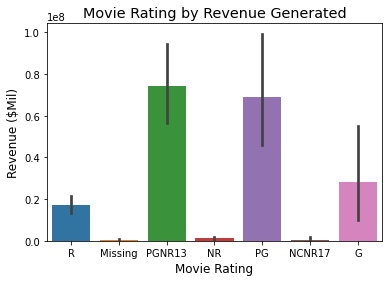

In [61]:
# 2b. visualize average revenue by rating
sns.barplot(data=tmdbYR_combo_df, x='certification',y='revenue')
plt.title('Movie Rating by Revenue Generated',fontsize='x-large')
plt.ylabel('Revenue ($Mil)', fontsize=12)
plt.xlabel('Movie Rating', fontsize=12);

### n > 2 so must use ANOVA Test

### Normality

### Equal variance

### No significant outliers

In [49]:
# Separate features data into groups

groups = {}
## Loop through all unique categories
for i in tmdbYR_combo_df['certification'].unique():
    ## Get series for group and rename
    data = tmdbYR_combo_df.loc[tmdbYR_combo_df['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()


dict_keys(['R', 'Missing', 'PGNR13', 'NR', 'PG', 'NCNR17', 'G'])

In [50]:
# 3a - check for Normality

## Running normal test on each group and confirming n > 15 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T # .T - transposes index and columns
norm_results_df

,n,p,test stat
R,1091.00,0.00,1544.04
Missing,18108.00,0.00,63169.78
PGNR13,541.00,0.00,689.52
NR,646.00,0.00,1060.21
PG,240.00,0.00,274.64
NCNR17,29.00,0.00,69.82
G,107.00,0.00,183.29


In [51]:
### 3b - checking significance with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
R,1091.00,0.00,1544.04,True
Missing,18108.00,0.00,63169.78,True
PGNR13,541.00,0.00,689.52,True
NR,646.00,0.00,1060.21,True
PG,240.00,0.00,274.64,True
NCNR17,29.00,0.00,69.82,True
G,107.00,0.00,183.29,True


### NOT normally distributed, but can safely disregard normality test results since n >15

In [52]:
# 4 - check for equal variance using * operator for groups dictionary values
stats.levene(*groups.values())

LeveneResult(statistic=305.4251190215026, pvalue=0.0)

### Did not meet the equal variance test, p < .05, so must run the Kruskal-Wallis Test instead of ANOVA

In [53]:
# 5 - Run Alternate Test:  Kruskal-Wallis 

result = stats.kruskal(*groups.values())
result

KruskalResult(statistic=3408.64031520395, pvalue=0.0)

## What was the p-value of you analysis?

## Kruskal-Wallis returned a single p_value < .05 representing a significant difference between ALL movie rating groups, so I 'reject' the null hypothesis.  The movie rating significantly impacts the revenue generated. 

Note:  Unfortunately, over 90% of the rating data was Missing from the years extracted, so the probability analysis is a bit ambiguous.


## Which rating earns the most revenue?

- PGNR13 rated movies generate the most revenue at $74Million on average

# 2. How do the years compare to revenue earned?

## This is a numerical problem

## Perform a statistical test to get a mathematically-supported answer.

- 1a. H(null):  The year in which a movie is made does NOT effect the revenue earned.

- 1b. H(Alt): The year in which a movie is made significantly effects the revenue earned.

In [54]:
## count movie year groups
tmdbYR_combo_df.groupby('release_year').size()

release_year
0        559
1919       1
1924       1
1951       1
1968       1
1979       1
1981       1
1985       1
1986       1
1992       1
1994       1
1996       2
1997       4
1998      12
1999      58
2000    2348
2001    2522
2002     145
2003      20
2004       8
2005       9
2006       1
2007       5
2008       4
2009       1
2010       2
2011       4
2012       1
2013       4
2014       9
2015      15
2016      37
2017     157
2018    6725
2019    7271
2020     641
2021     157
2022      30
2023       1
dtype: int64

In [55]:
## 2a. mean for movie release year groups by revenue
year_rev_mean = tmdbYR_combo_df.groupby('release_year')['revenue'].mean()
year_rev_mean

release_year
0          536.71
1919         0.00
1924         0.00
1951         0.00
1968         0.00
1979         0.00
1981         0.00
1985         0.00
1986         0.00
1992         0.00
1994         0.00
1996         0.00
1997         0.00
1998         0.00
1999       440.34
2000   5546661.08
2001   6132503.02
2002     97412.38
2003         0.00
2004         0.00
2005         0.00
2006         0.00
2007         0.00
2008         0.00
2009         0.00
2010         0.00
2011         0.00
2012         0.00
2013         0.00
2014         0.00
2015         0.00
2016         0.00
2017     14085.81
2018   4565965.55
2019   4100704.09
2020     70201.24
2021     41622.08
2022    177199.83
2023         0.00
Name: revenue, dtype: float64

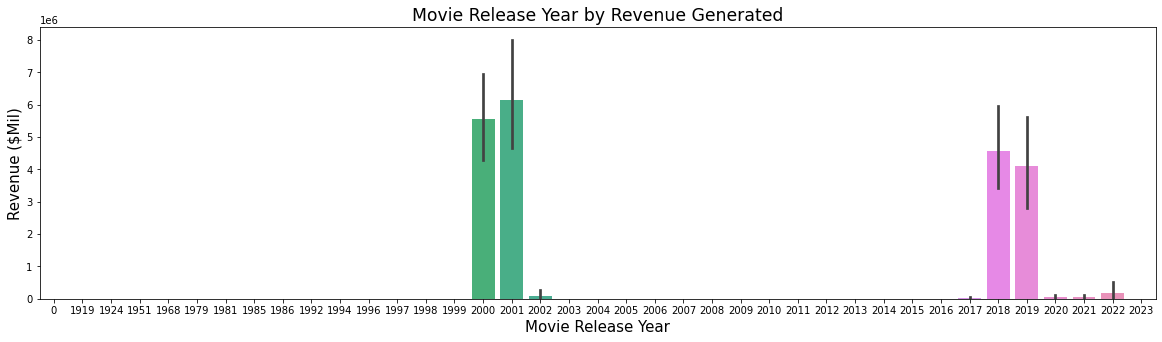

In [62]:
# 2b. visualize average revenue by rating
plt.subplots(figsize=(20,5))
sns.barplot(data=tmdbYR_combo_df, x='release_year',y='revenue')
plt.title('Movie Release Year by Revenue Generated',fontsize='xx-large')
plt.ylabel('Revenue ($Mil)', fontsize=15)
plt.xlabel('Movie Release Year', fontsize=15);

### n > 2 so must use ANOVA Test

### Normality

### Equal variance

### No significant outliers

In [63]:
# Separate features data into groups

groups = {}
## Loop through all unique categories
for i in tmdbYR_combo_df['release_year'].unique():
    ## Get series for group and rename
    data = tmdbYR_combo_df.loc[tmdbYR_combo_df['release_year']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys([2018, 2020, 2002, 2019, 0, 2021, 2016, 2017, 2022, 2008, 2009, 2015, 2012, 2013, 2014, 2011, 1924, 2000, 1997, 1999, 1998, 2001, 2005, 2003, 1996, 2007, 2010, 1992, 2004, 1919, 1981, 1968, 1951, 2023, 1979, 1985, 2006, 1986, 1994])

### 3a - check for Normality

### Planned to do the ANOVA test, but generated a ValueError when testing for normality (ValueError: skewtest is not valid with less than 8 samples; 4 samples were given.)

### Since N is not large enough, must now select a non-parametric equivalent test

In [67]:
# 4 - Run Alternate Test:  Kruskal-Wallis 

result = stats.kruskal(*groups.values())
print(result)
result.pvalue < .05

KruskalResult(statistic=150.9686253227303, pvalue=2.1316068785387382e-15)


True

## What was the p-value of you analysis?

## p_value < alpha (0.05), so I reject the null hypothesis and accept that there is a significantly higher difference in movie revenue generated between movie release years of 2000, 2001, 2018, and 2019.

Note:  Year 2001 had the highest movie revenue while Year 2019 had the lowest movie revenue based on sufficient N (sample size).

## 3. Does the Adventure movie genre generate more revenue than movies NOT in the Adventure genre?

## Perform a statistical test to get a mathematically-supported answer.

H(null):  There is no difference in movie revenue generated based on movie genre.

H(Alt):  The movie revenue generated for Adventure movies is significantly higher than revenue generated in other genres.


In [68]:
#tmdbYR_combo_df['Genre_Action'].value_counts()

False    18792
True      1970
Name: Genre_Action, dtype: int64

In [83]:
#tmdbYR_combo_df['Genre_Fantasy'].value_counts()

False    19983
True       779
Name: Genre_Fantasy, dtype: int64

In [97]:
#tmdbYR_combo_df['Genre_Family'].value_counts()

False    19743
True      1019
Name: Genre_Family, dtype: int64

In [98]:
#tmdbYR_combo_df['Genre_History'].value_counts()

False    20163
True       599
Name: Genre_History, dtype: int64

In [99]:
#tmdbYR_combo_df['Genre_TV Movie'].value_counts()

False    20635
True       127
Name: Genre_TV Movie, dtype: int64

In [100]:
#tmdbYR_combo_df['Genre_War'].value_counts()

False    20443
True       319
Name: Genre_War, dtype: int64

In [121]:
#tmdbYR_combo_df['Genre_Western'].value_counts()

False    20657
True       105
Name: Genre_Western, dtype: int64

In [74]:
# Explore mean values for features
# action_genre_mean = tmdbYR_combo_df.groupby('Genre_Action')['revenue'].mean()
# action_genre_mean

Genre_Action
False    2567155.82
True    20732786.80
Name: revenue, dtype: float64

In [84]:
# fantasy_genre_mean = tmdbYR_combo_df.groupby('Genre_Fantasy')['revenue'].mean()
# fantasy_genre_mean

Genre_Fantasy
False    3529158.51
True    23828507.87
Name: revenue, dtype: float64

In [86]:
# family_genre_mean = tmdbYR_combo_df.groupby('Genre_Family')['revenue'].mean()
# family_genre_mean

Genre_Family
False    3651763.66
True    16672043.42
Name: revenue, dtype: float64

In [87]:
# history_genre_mean = tmdbYR_combo_df.groupby('Genre_History')['revenue'].mean()
# history_genre_mean

Genre_History
False   4188182.24
True    7745014.50
Name: revenue, dtype: float64

In [90]:
# tvmovie_genre_mean = tmdbYR_combo_df.groupby('Genre_TV Movie')['revenue'].mean()
# tvmovie_genre_mean

Genre_TV Movie
False   4317207.76
True          0.00
Name: revenue, dtype: float64

In [91]:
# war_genre_mean = tmdbYR_combo_df.groupby('Genre_War')['revenue'].mean()
# war_genre_mean

Genre_War
False   4218492.88
True    8924552.18
Name: revenue, dtype: float64

In [119]:
# western_genre_mean = tmdbYR_combo_df.groupby('Genre_Western')['revenue'].mean()
# western_genre_mean

Genre_Western
False   4304806.03
True    1535276.34
Name: revenue, dtype: float64

In [69]:
# Explore movie genre revenues

## Count genre movies (bool=True)
tmdbYR_combo_df['Genre_Animation'].value_counts()

False    20147
True       615
Name: Genre_Animation, dtype: int64

In [96]:
tmdbYR_combo_df['Genre_Adventure'].value_counts()

False    19937
True       825
Name: Genre_Adventure, dtype: int64

In [128]:
## Filtering out Adventure and Animation genres to separate variables
adventure_true = tmdbYR_combo_df[tmdbYR_combo_df["Genre_Adventure"]]
adventure_true

,imdb_id,adult,belongs_to_collection,budget,popularity,revenue,runtime,title,vote_average,vote_count,...,Genre_Action,Genre_Fantasy,Genre_Family,Genre_History,Genre_TV Movie,Genre_Animation,Genre_Adventure,Genre_Western,Genre_War,release_year
105,tt10443316,0.00,False,0.00,4.07,0.00,66.00,Monkey Magic,0.00,0.00,...,False,True,False,False,False,True,True,False,False,2018
109,tt10443760,0.00,False,0.00,1.10,0.00,94.00,Fade Away Pastoral,0.00,0.00,...,False,False,False,False,False,False,True,True,False,2018
113,tt10449188,0.00,False,0.00,0.81,0.00,0.00,Love Trip,0.00,0.00,...,False,False,False,False,False,False,True,False,False,2018
127,tt10488892,0.00,False,0.00,0.60,0.00,89.00,The Redtails,0.00,0.00,...,False,False,False,False,False,False,True,False,False,2018
131,tt10499426,0.00,False,0.00,2.06,0.00,50.00,Pocoyo in cinemas: Your First Movie,5.00,1.00,...,False,False,False,False,False,True,True,False,False,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20530,tt0832449,0.00,True,0.00,45.26,0.00,60.00,One Piece: Clockwork Island Adventure,6.80,187.00,...,True,False,False,False,False,True,True,False,False,2001
20541,tt0971215,0.00,False,0.00,1.24,0.00,88.00,Shenmue: The Movie,5.40,5.00,...,True,False,False,False,False,True,True,False,False,2001
20637,tt1967539,0.00,True,0.00,2.05,0.00,70.00,Kamen Rider Agito: Project G4,4.50,2.00,...,True,False,False,False,False,False,True,False,False,2001
20699,tt4184478,0.00,False,0.00,0.60,0.00,76.00,The Future World,5.00,1.00,...,False,True,False,False,False,False,True,False,False,2001


In [129]:
animation_true = tmdbYR_combo_df[tmdbYR_combo_df["Genre_Animation"]]
animation_true

,imdb_id,adult,belongs_to_collection,budget,popularity,revenue,runtime,title,vote_average,vote_count,...,Genre_Action,Genre_Fantasy,Genre_Family,Genre_History,Genre_TV Movie,Genre_Animation,Genre_Adventure,Genre_Western,Genre_War,release_year
79,tt10292620,0.00,False,0.00,0.60,0.00,70.00,Timescapes,0.00,0.00,...,False,False,False,False,False,True,False,False,False,2017
105,tt10443316,0.00,False,0.00,4.07,0.00,66.00,Monkey Magic,0.00,0.00,...,False,True,False,False,False,True,True,False,False,2018
107,tt10443580,0.00,True,0.00,0.60,0.00,62.00,Go! Anpanman: Shine! Kulun and the Stars of Life,7.00,1.00,...,False,True,False,False,False,True,False,False,False,2018
112,tt10449120,0.00,False,0.00,1.40,0.00,76.00,The Daily Fable,4.00,1.00,...,False,False,True,False,False,True,False,False,False,2018
119,tt10453164,0.00,False,0.00,2.80,0.00,0.00,Paw Patrol: Sea Patrol,8.00,2.00,...,False,False,False,False,False,True,False,False,False,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20541,tt0971215,0.00,False,0.00,1.24,0.00,88.00,Shenmue: The Movie,5.40,5.00,...,True,False,False,False,False,True,True,False,False,2001
20552,tt1073223,0.00,True,0.00,10.86,0.00,100.00,Case Closed: Countdown to Heaven,7.10,121.00,...,True,False,False,False,False,True,False,False,False,2001
20565,tt1164584,0.00,False,0.00,1.40,0.00,50.00,Hamtaro: Adventures in Ham-Ham Land,10.00,1.00,...,False,True,True,False,False,True,False,False,False,2001
20618,tt1612776,0.00,False,0.00,0.60,0.00,100.00,Short6,8.00,1.00,...,True,False,False,False,False,True,False,False,False,2001


In [85]:
adventure_genre_mean = tmdbYR_combo_df.groupby('Genre_Adventure')['revenue'].mean()
adventure_genre_mean

Genre_Adventure
False    2293731.23
True    52552075.76
Name: revenue, dtype: float64

In [72]:
# Explore mean values for features
animation_genre_mean = tmdbYR_combo_df.groupby('Genre_Animation')['revenue'].mean()
animation_genre_mean

Genre_Animation
False    3690875.69
True    23943917.93
Name: revenue, dtype: float64

In [131]:
# Define feature of interest
adventure_true_rev = adventure_true['revenue'].mean()
animation_true_rev = animation_true['revenue'].mean()

In [132]:
adventure_true_rev

52552075.75878788

In [133]:
animation_true_rev

23943917.9300813

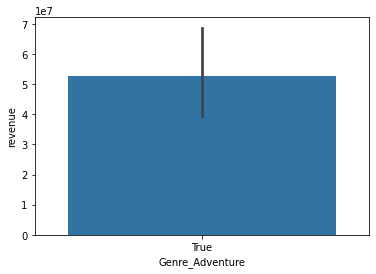

In [134]:
# visualize average Adventure genre revenue by genre
sns.barplot(data=adventure_true, x='Genre_Adventure',y='revenue');

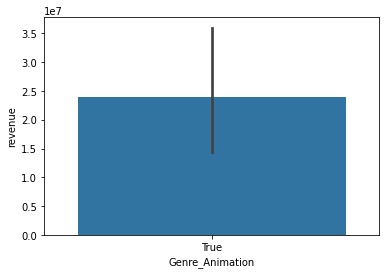

In [135]:
# visualize average Animation genre revenue by genre
sns.barplot(data=animation_true, x='Genre_Animation',y='revenue');

In [ ]:
# What was the p-value of you analysis?

In [ ]:
# Which movie genre earns the most revenue?

In [ ]:
# Prepare a visualization that supports your finding.

## Do some popular movies earn revenue that at least doubles their budget?

